# 사전작업

* 구글 드라이브 마운트

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


:# (**@@처음 1회만 실행@@)** 공유 드라이브 위성사진 이미지 압축파일 압축 해제 (오래걸림)

In [ ]:
# 최초 1회만
%cd /content/drive/Shareddrives/settle_img  # 압축을 풀 경로 -> 공유 드라이브로 접근

!unzip -qq "/content/drive/Shareddrives/settle_img/image_dataset.zip"

[Errno 2] No such file or directory: '/content/drive/Shareddrives/settle_img # 압축을 풀 경로 -> 공유 드라이브로 접근'
/content


# Module import

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # device

import csv
import pandas as pd
import cv2
import shutil
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font', family='NanumBarunGothic') # plotting 시 한글 깨짐현상 방지
print(device)

cuda:0


# ------------------------------------------------- [ 데이터 가공 ] -------------------------------------------------
# - 김영빈 작업 중

# 하이퍼 파라미터 & 경로 설정

In [ ]:
#path = '/content/drive/Shareddrives/settle_img/image_dataset'  # 이미지 파일 경로
path = '/content/image_dataset/'  # 압축 풀어서 사용하는 이미지 경로
csv_data = "/content/drive/Shareddrives/settle_img/weather.csv" # CSV 파일 경로 (공유 드라이브)

# 이미지 폴더 정리 시 필요한 경로
DS_Store_path = '/content/image_dataset/.DS_Store'  # 맥에서 생성되는 .DS_Store 파일 제거용
dir_path = '/content/image_dataset/image_dataset' # 실수로 압축해제 코드 돌렸을 때 생기는 폴더 제거용
MACOSX_path = '/content/drive/Shareddrives/settle_img/image_dataset/__MACOSX'
# path = 'C:\\Users\\JeongBeom\\Documents\\DL_course\\image_dataset'
# csv_data = 'C:\\Users\\JeongBeom\\Documents\\DL_course\\weather.csv'

# DS_Store_path = 'C:\\Users\\JeongBeom\\Documents\\DL_course\\image_dataset\\.DS_Store'
# dir_path = 'C:\\Users\\JeongBeom\\Documents\\DL_course\\image_dataset\\image_dataset'

SEQUENCE_LENGTH = 6 # Sequence Length 설정
BATCH_SIZE = 32 # Batch Size 설정

# 위성영상 이미지 데이터  -  Load & 전처리
[ 최종 데이터 ]

final_train_images

final_test_images

* 이미지 데이터 경로, 파일명 불러오기 및 이미지 데이터 수 확인

In [ ]:
# 파일명 불러오기

os.chdir(path)  # 해당 폴더로 이동

# --------------------- 파일개수 안 맞을 시 처리 코드 ----------------------------------
# .DS_Store 파일 제거
if os.path.exists(DS_Store_path):
    os.remove(DS_Store_path)
# if os.path.exists(MACOSX_path):
#    shutil.rmtree(MACOSX_path)
# 실수로 압축해제 코드 돌려서 image_dataset 폴더 안에 image_dataset 폴더 다시 생길 경우 하나 더 생가는 폴더 제거
if os.path.exists(dir_path):
  shutil.rmtree(dir_path)
# ----------------------------------------------------------------------------------


files = os.listdir(path)  # 해당 폴더에 있는 파일들의 이름을 리스트 형태로 받아옴
files.sort()  # 파일 이름 순서대로 정렬
#files = files[:10000]
# 파일 내용,길이 확인
print(files)  # 2019072500.png 부터 시작하는지 확인
print(len(files)) # 이미지 데이터 24529개

# 중복 파일 삭제
# for duplicate in files:
#   if "(" in duplicate:
#     files.remove(duplicate)

# print(files)  # 2019072500.png 부터 시작하는지 확인
# print(len(files)) # 이미지 데이터 24529개

['2019072500.png', '2019072501.png', '2019072502.png', '2019072503.png', '2019072504.png', '2019072505.png', '2019072506.png', '2019072507.png', '2019072508.png', '2019072509.png', '2019072510.png', '2019072511.png', '2019072512.png', '2019072513.png', '2019072514.png', '2019072515.png', '2019072516.png', '2019072517.png', '2019072518.png', '2019072519.png', '2019072520.png', '2019072521.png', '2019072522.png', '2019072523.png', '2019072600.png', '2019072601.png', '2019072602.png', '2019072603.png', '2019072604.png', '2019072605.png', '2019072606.png', '2019072607.png', '2019072608.png', '2019072609.png', '2019072610.png', '2019072611.png', '2019072612.png', '2019072613.png', '2019072614.png', '2019072615.png', '2019072616.png', '2019072617.png', '2019072618.png', '2019072619.png', '2019072620.png', '2019072621.png', '2019072622.png', '2019072623.png', '2019072700.png', '2019072701.png', '2019072702.png', '2019072703.png', '2019072704.png', '2019072705.png', '2019072706.png', '20190727

* 위성사진 이미지 가공 함수 정의

In [ ]:
# [ 이미지 가공 함수 ] - 인자로 이미지 파일들의 이름이 들어있는 리스트를 받아준다.
def image_processing(files):
  weather_images = [] # 가공된 이미지 담을 배열
  for file in files:
    img = cv2.imread(file, cv2.IMREAD_COLOR)  # 파일 이름 리스트를 사용하여 이미지 컬러로 받아옴 (900, 900, 3)
    # # 이미지 누락 확인
    # print(img.shape)
    # print(i)
    fixed_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # opencv로 불러오는 이미지는 Blue / Red / Green 순서임  ==>  RGB로 바꿔줌

    r, g, b = cv2.split(fixed_img)  # RGB 이미지에서 Blue 채널 추출 (900, 900)
    b = b[140:730, 300:670] # Blue 채널 이미지 한반도에 맞춰서 자르기
    resized_b = cv2.resize(b, dsize=(100, 100), interpolation=cv2.INTER_AREA)  # 해상도 (100 x 100)로 축소
    #resized_b.astype(np.float64)

    weather_images.append(resized_b)  # 가공된 이미지 파일 담아주기

  return weather_images



# # 이미지 파일 하나만 가공해서 확인해보는 코드 (동작 확인 용)
# print(files[0]) # 2019072500.png
# img = cv2.imread(files[0], cv2.IMREAD_COLOR)    # 파일 이름 리스트를 사용하여 이미지 컬러로 받아옴 (900, 900, 3)
# # plt.imshow(img)
# # plt.show()
# print(img.shape) # (900, 900, 3)
# fixed_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # opencv로 불러오는 이미지는 Blue / Red / Green 순서임  ==>  RGB로 바꿔줌
# # plt.imshow(fixed_img)
# # plt.show()

# r, g, b = cv2.split(fixed_img)    # Blue 채널 추출 (900, 900)
# print(b.shape)  # (900, 900)
# b = b[140:730, 300:670] # Blue 채널 이미지 자르기
# # plt.imshow(b)
# # plt.show()
# resized_b = cv2.resize(b, dsize=(224, 224), interpolation=cv2.INTER_AREA)   # 해상도 (100 x 100)로 축소
# print(resized_b.shape)  # (224, 224)
# # 가공된 이미지 확인
# plt.imshow(resized_b)
# plt.show()
# resized_b = torch.tensor(np.array(resized_b))
# resized_b = torch.reshape(resized_b, (1, resized_b.shape[0], resized_b.shape[1]))
# print(resized_b)
# print(resized_b.shape)  # torch.Size([1, 224, 224])

* 이미지 가공 수행 및 가공 확인 (13분 정도 소요)

In [ ]:
input_images = image_processing(files) # 이미지 가공 함수 실행

# 가공 확인
print(len(input_images))  # 24529개 확인
print(input_images[0]) # 가공된 이미지 하나만 확인
print(input_images[0].shape)  # (100, 100)
print(type(input_images[0]))  # <class 'numpy.ndarray'>

24529
[[ 39  39  41 ... 187 162 168]
 [ 45  35  35 ... 191 197 170]
 [ 36  31  32 ... 201 196 198]
 ...
 [149 144 124 ...  95  47  43]
 [ 87  46  50 ...  59  44  42]
 [ 43  22  23 ...  22  33  33]]
(100, 100)
<class 'numpy.ndarray'>


* 이미지 시퀀스 그룹 별 분리 함수 정의 (이미지는 인풋으로만 사용되므로 인풋 시퀀스만 만들면 됨)

In [ ]:
# 주어진 sequence에 맞게 데이터 나눠주기
def image_adjust_sequence(data, seq_length):
  x = []

  # input sequence로 사용 가능한 데이터 범위 탐색
  for i in range(len(data)-seq_length):
    x_temp = data[i:(i+seq_length)] # i번째 부터 sequence 길이만큼의 데이터들을 묶어준다. (6개가 연속된 1개의 sequence 데이터)
    x.append(x_temp)  # 묶어준 sequence 데이터를 x에 넣어준다.

  return x  # sequence대로 새로 묶인 input 리턴

* 이미지 시퀀스 그룹 별 분리 함수 실행 및 확인

In [ ]:
input_images_sequence = image_adjust_sequence(input_images, SEQUENCE_LENGTH)  # 시퀀스 그룹 분리 함수 실행

# 잘 분류됐는지 확인
print(len(input_images_sequence)) # sequence_length = 6 일 경우 인풋으로 사용될 이미지 시퀀스 총 24523개
print(input_images_sequence[0]) # 이미지 리스트 6개 출력 확인

print(type(input_images_sequence))  # <class 'list'>

# print(input_images_sequence.shape)  # (24523, 6, 100, 100)
# print(type(input_images_sequence))  # 넘파이 리스트

24523
[array([[ 39,  39,  41, ..., 187, 162, 168],
       [ 45,  35,  35, ..., 191, 197, 170],
       [ 36,  31,  32, ..., 201, 196, 198],
       ...,
       [149, 144, 124, ...,  95,  47,  43],
       [ 87,  46,  50, ...,  59,  44,  42],
       [ 43,  22,  23, ...,  22,  33,  33]], dtype=uint8), array([[ 53,  89,  86, ..., 144, 166, 179],
       [ 71,  54,  47, ..., 148, 172, 178],
       [ 61,  49,  54, ..., 150, 158, 155],
       ...,
       [151, 129,  98, ..., 163, 159, 118],
       [122, 112, 110, ..., 159, 132,  54],
       [ 40,  49,  65, ...,  64,  53,  42]], dtype=uint8), array([[ 43,  43,  43, ..., 180, 201, 189],
       [ 28,  26,  29, ..., 237, 239, 195],
       [ 22,  27,  45, ..., 250, 242, 198],
       ...,
       [156, 136, 109, ..., 124,  98, 108],
       [135,  95,  56, ..., 117, 122, 129],
       [ 74,  77,  83, ...,  84, 117,  81]], dtype=uint8), array([[ 54,  40,  74, ..., 115, 157, 161],
       [ 51,  42,  49, ...,  98, 123, 148],
       [ 51,  39,  29, ..., 118,

* 위성영상 이미지 Train & Test 분리

In [ ]:
# Train 데이터와 Test 데이터를 나눠준다.
# Test 데이터의 시작 날짜가 2022.1.1 00:00가 되도록 인덱스 나눠주었음
def image_train_test_divide(x, seq_length):
    train_img = x[:21384-seq_length+1]
    test_img = x[21384:]

    return train_img, test_img


# 학습용 이미지, 테스트용 이미지로 나눠주기
train_images_sequences, test_images_sequences = image_train_test_divide(input_images_sequence, SEQUENCE_LENGTH)


# 잘 분류됐는지 확인
print('--------------------------[ Train images ]--------------------------')
print(len(train_images_sequences)) # 21379
#print(train_images_sequences.shape) # (21379, 6, 100, 100)
print('--------------------------[ Test images ]--------------------------')
print(len(test_images_sequences)) # 3139
#print(test_images_sequences.shape) # (3139, 6, 100, 100)
print(type(test_images_sequences))  # <class 'list'>

--------------------------[ Train images ]--------------------------
21379
--------------------------[ Test images ]--------------------------
3139
<class 'list'>


* 데이터 Batch 단위만큼 나눠주는 함수

In [ ]:
def adjust_batch(data, batch_size):
  batch_group = []
  for i in range(0, len(data), batch_size):
    batch_group.append(data[i:i+batch_size]) # batch 한 덩어리 만큼 묶인 배치 데이터를 batch_group 리스트에 담아준다.
  return batch_group

* 데이터 Batch 단위만큼 나눠주기

In [ ]:
# Batch 나누기

batch_train_images = adjust_batch(train_images_sequences, BATCH_SIZE)
batch_test_images = adjust_batch(test_images_sequences, BATCH_SIZE)

print('------------------ Batch -------------------') # batch 묶음 개수 확인
print('batch_train_images :', len(batch_train_images))  # 669
# batch_train_images[0].shape : (32, 6, 100, 100)
print('batch_test_images :', len(batch_test_images))  # 99
# batch_test_images[0].shape  : (32, 6, 100, 100)

print(type(batch_train_images)) # <class 'list'>
print(type(batch_train_images[0]))  # <class 'list'>

------------------ Batch -------------------
batch_train_images : 669
batch_test_images : 99
<class 'list'>
<class 'list'>


* Batch 데이터 tensor 형태로 변환하는 함수

In [ ]:
def change_tensor_images(batch_data):
  for i in range(len(batch_data)):
    batch_data[i] = np.array(batch_data[i])
    batch_data[i] = torch.tensor(batch_data[i]) # 배치 데이터들을 tensor 형태로 변환
    batch_data[i] = batch_data[i].unsqueeze(dim=2)  # image.shape = (batch, seq_lenth, c, h, w) 을 맞춰주기 위해 channel 의 차원 1 추가해줌

  return batch_data

* 학습할 수 있도록 tensor 형태로 변환

In [ ]:
# image.shape = (batch, seq_lenth, c, h, w)

final_train_images = change_tensor_images(batch_train_images)
final_test_images = change_tensor_images(batch_test_images)

print('final_train_images :', len(final_train_images), final_train_images[0].shape) # 669 torch.Size([32, 6, 1, 100, 100])
print('final_test_images :', len(final_test_images), final_test_images[0].shape)  # 99 torch.Size([32, 6, 1, 100, 100])

final_train_images : 669 torch.Size([32, 6, 1, 100, 100])
final_test_images : 99 torch.Size([32, 6, 1, 100, 100])


# CSV 날씨 데이터  -  Load & 전처리
[ 최종 데이터 ]

final_train_x, final_train_y

final_test_x, final_test_y

* CSV 날씨 데이터 불러오기

In [ ]:
# EUC_KR로 저장된 날씨데이터 csv 파일 읽기
df = pd.read_csv(csv_data, encoding='euc_kr', header=0)
df["일시"] = pd.to_datetime(df["일시"]) # '일시' column의 자료형 문자열 -> datetime으로 바꿔줌
df = df.fillna(0.0) # NaN값 0.0으로 채워줌
#df = df[:10000]
print('----------------------- [ 불러온 날씨데이터 확인 ] -----------------------')
display(df)
print('----------------------- [ 데이터프레임 행,열 확인 ] -----------------------')
print(df.shape) # (24529, 9)
print('----------------------- [ 칼럼 별 자료형 확인 ] -----------------------')
print(df.dtypes)

print('----------------------- [ 2020-08-26 13:00 기온 누락 수정 ] --------------')
display(df[9564:9567])
df.loc[9565, '기온(°C)'] = 34.5 # 해당 시간 실제 기온
display(df[9564:9567])

----------------------- [ 불러온 날씨데이터 확인 ] -----------------------


,지점,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),지면온도(°C)
0,108,2019-07-25 00:00:00,26.8,0.0,1.0,110.0,79.0,995.1,25.5
1,108,2019-07-25 01:00:00,26.6,0.0,0.8,50.0,82.0,994.7,25.5
2,108,2019-07-25 02:00:00,26.6,0.0,0.5,110.0,81.0,994.6,25.6
3,108,2019-07-25 03:00:00,26.7,0.0,0.8,110.0,79.0,994.6,25.6
4,108,2019-07-25 04:00:00,26.1,0.3,0.5,50.0,93.0,994.4,25.5
...,...,...,...,...,...,...,...,...,...
24524,108,2022-05-11 20:00:00,18.6,0.0,2.5,270.0,54.0,1004.2,18.4
24525,108,2022-05-11 21:00:00,17.8,0.0,2.6,270.0,58.0,1004.6,16.9
24526,108,2022-05-11 22:00:00,17.0,0.0,2.9,270.0,63.0,1005.3,15.6
24527,108,2022-05-11 23:00:00,16.7,0.0,2.7,250.0,63.0,1005.1,15.2


----------------------- [ 데이터프레임 행,열 확인 ] -----------------------
(24529, 9)
----------------------- [ 칼럼 별 자료형 확인 ] -----------------------
지점                    int64
일시           datetime64[ns]
기온(°C)              float64
강수량(mm)             float64
풍속(m/s)             float64
풍향(16방위)            float64
습도(%)               float64
현지기압(hPa)           float64
지면온도(°C)            float64
dtype: object
----------------------- [ 2020-08-26 13:00 기온 누락 수정 ] --------------


,지점,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),지면온도(°C)
9564,108,2020-08-26 12:00:00,33.3,0.0,3.0,70.0,60.0,993.6,38.4
9565,108,2020-08-26 13:00:00,0.0,0.0,4.3,70.0,60.0,993.0,35.9
9566,108,2020-08-26 14:00:00,34.1,0.0,4.0,90.0,58.0,992.2,38.0


,지점,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),지면온도(°C)
9564,108,2020-08-26 12:00:00,33.3,0.0,3.0,70.0,60.0,993.6,38.4
9565,108,2020-08-26 13:00:00,34.5,0.0,4.3,70.0,60.0,993.0,35.9
9566,108,2020-08-26 14:00:00,34.1,0.0,4.0,90.0,58.0,992.2,38.0


* 데이터 Sequence 그룹 별로 나누는 함수 정의

In [ ]:
# 주어진 sequence에 맞게 데이터 나눠주기
def adjust_sequence(data, seq_length):
  x = []
  y = []
  input_form = data.iloc[:, 2:9] # input으로 사용할 features : 기온(°C) 강수량(mm) 풍속(m/s) 풍향(16방위) 습도(%) 현지기압(hPa) 지면온도(°C) 만 남김
  output_form = data.iloc[:, [2,3,6]]  # output으로 시용할 features : 기온(°C) 강수량(mm) 습도(%) 만 남김

  # Input 데이터 정규화
  input_form = (input_form - input_form.mean()) / input_form.std()
  #output_form = (output_form - output_form.mean()) / output_form.std()

  # Input으로 사용할 데이터 sequence 분류 -> 이미지 데이터와 동일하게 처리
  for i in range(len(data)-seq_length):
    x_temp = input_form[i:(i+seq_length)]
    x.append(x_temp)

  # output으로 사용할 데이터 -> 각각의 Input sequence에서 한시간 뒤의 데이터
  for j in range(seq_length, len(data)):
    y_temp = output_form[j:j+1]
    y.append(y_temp)

  return x, y # sequence 데이터로 가공된 input과 output을 리턴

* 데이터 sequence 분류 수행 및 확인

In [ ]:
x, y = adjust_sequence(df, SEQUENCE_LENGTH) # sequence 그룹 별 분류 함수 실행

# 잘 분류됐는지 확인
print('-----------------------------------[ Input sequence data ]--------------------------------------')
print(len(x))
display(x[0])
display(x[-1])
print('-----------------------------------[ Output sequence data ]--------------------------------------')
print(len(y))
display(y[0])
display(y[-1])
# x, y는 sequence만큼의 Dataframe들이 연속된 리스트

-----------------------------------[ Input sequence data ]--------------------------------------
24523


,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),지면온도(°C)
0,1.309406,-0.120214,-1.133292,-0.726861,0.824155,-0.455358,0.932639
1,1.290638,-0.120214,-1.305790,-1.271518,0.980170,-0.471658,0.932639
2,1.290638,-0.120214,-1.564535,-0.726861,0.928165,-0.475733,0.940744
3,1.300022,-0.120214,-1.305790,-0.726861,0.824155,-0.475733,0.940744
4,1.243717,0.124129,-1.564535,-1.271518,1.552225,-0.483883,0.932639
5,1.215564,0.042681,-1.737033,-1.725399,1.656235,-0.475733,0.932639


,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),지면온도(°C)
24522,0.783893,-0.120214,1.022923,0.725558,-0.788001,-0.108985,0.965060
24523,0.652515,-0.120214,0.246685,0.725558,-0.527976,-0.100836,0.584104
24524,0.539905,-0.120214,0.160437,0.725558,-0.475971,-0.084536,0.357151
24525,0.464831,-0.120214,0.246685,0.725558,-0.267951,-0.068236,0.235569
24526,0.389758,-0.120214,0.505431,0.725558,-0.007926,-0.039711,0.130198
24527,0.361606,-0.120214,0.332934,0.544006,-0.007926,-0.047861,0.097776


-----------------------------------[ Output sequence data ]--------------------------------------
24523


,기온(°C),강수량(mm),습도(%)
6,25.6,0.8,96.0


,기온(°C),강수량(mm),습도(%)
24528,16.6,0.0,64.0


* Train & Test 데이터 분리

In [ ]:
# Train 데이터와 Test 데이터를 나눠준다.
# Test 데이터의 가장 첫번째 시퀀스 데이터의 첫번째 일시가 2022.1.1 00:00이 되도록 나눠줌
def train_test_divide(x, y, seq_length):
  # trainX = x[:4000]
  # trainY = y[:4000]
  trainX = x[:21384-seq_length+1]
  trainY = y[:21384-seq_length+1]

  # testX = x[4000:]
  # testY = y[4000:]
  testX = x[21384:]
  testY = y[21384:]

  return trainX, trainY, testX, testY


# 학습용, 테스트용 input(X), output(Y) 나눠줌
train_x, train_y, test_x, test_y = train_test_divide(x, y, SEQUENCE_LENGTH)


# 잘 분류됐는지 확인
print('----------------------------------[ Train ]-----------------------------------')
print(len(train_x), len(train_y)) # 21379
print('----------------------------------[ Train data ]-----------------------------------')
# display(train_x[0])
# display(train_x[-1])
display(train_x)
print('----------------------------------[ Train label ]-----------------------------------')
display(train_y[0])
display(train_y[-1])

print('----------------------------------[ Test ]-----------------------------------')
print(len(test_x), len(test_y)) # 3139
print('----------------------------------[ Test data ]-----------------------------------')
display(test_x[0])
display(test_x[-1])
print('----------------------------------[ Test label ]-----------------------------------')
display(test_y[0])
display(test_y[-1])

----------------------------------[ Train ]-----------------------------------
21379 21379
----------------------------------[ Train data ]-----------------------------------


,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),지면온도(°C)
0,1.309406,-0.120214,-1.133292,-0.726861,0.824155,-0.455358,0.932639
1,1.290638,-0.120214,-1.305790,-1.271518,0.980170,-0.471658,0.932639
2,1.290638,-0.120214,-1.564535,-0.726861,0.928165,-0.475733,0.940744
3,1.300022,-0.120214,-1.305790,-0.726861,0.824155,-0.475733,0.940744
4,1.243717,0.124129,-1.564535,-1.271518,1.552225,-0.483883,0.932639
5,1.215564,0.042681,-1.737033,-1.725399,1.656235,-0.475733,0.932639


,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),지면온도(°C)
21378,-1.759215,-0.120214,-0.098309,0.362453,-1.620082,0.575610,-1.409841
21379,-1.806136,-0.120214,-0.098309,0.544006,-1.516072,0.604135,-1.499001
21380,-1.796752,-0.120214,1.540414,1.179439,-1.464067,0.608210,-1.563844
21381,-1.834288,-0.120214,2.144155,1.179439,-1.412062,0.608210,-1.596266
21382,-1.909361,-0.120214,0.591680,1.179439,-1.360057,0.632660,-1.636794
21383,-1.928130,-0.120214,0.505431,1.179439,-1.308052,0.636735,-1.661110


----------------------------------[ Train label ]-----------------------------------


,기온(°C),강수량(mm),습도(%)
6,25.6,0.8,96.0


,기온(°C),강수량(mm),습도(%)
21384,-8.5,0.0,41.0


----------------------------------[ Test ]-----------------------------------
3139 3139
----------------------------------[ Test data ]-----------------------------------


,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),지면온도(°C)
21384,-2.003203,-0.120214,-0.357055,1.179439,-1.152037,0.636735,-1.701637
21385,-2.068892,-0.120214,-0.443304,0.725558,-1.100032,0.648960,-1.717848
21386,-2.097045,-0.120214,-0.960795,0.725558,-1.048027,0.653034,-1.742165
21387,-2.078276,-0.120214,-0.788298,0.907111,-0.892011,0.665259,-1.750270
21388,-2.106429,-0.120214,-0.529552,1.360991,-0.788001,0.636735,-1.750270
21389,-2.115813,-0.120214,-1.305790,0.725558,-0.631986,0.640810,-1.758376


,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),지면온도(°C)
24522,0.783893,-0.120214,1.022923,0.725558,-0.788001,-0.108985,0.965060
24523,0.652515,-0.120214,0.246685,0.725558,-0.527976,-0.100836,0.584104
24524,0.539905,-0.120214,0.160437,0.725558,-0.475971,-0.084536,0.357151
24525,0.464831,-0.120214,0.246685,0.725558,-0.267951,-0.068236,0.235569
24526,0.389758,-0.120214,0.505431,0.725558,-0.007926,-0.039711,0.130198
24527,0.361606,-0.120214,0.332934,0.544006,-0.007926,-0.047861,0.097776


----------------------------------[ Test label ]-----------------------------------


,기온(°C),강수량(mm),습도(%)
21390,-9.8,0.0,53.0


,기온(°C),강수량(mm),습도(%)
24528,16.6,0.0,64.0


* 데이터 Batch 단위만큼 나눠주기

In [ ]:
# 리스트 -> 넘파이 리스트로 변환
train_x = np.array(train_x)
train_y = np.array(train_y)

test_x = np.array(test_x)
test_y = np.array(test_y)
print("Training shape : ", train_x.shape, train_y.shape)
print("Testing shape : ", test_x.shape, test_y.shape)
# Training shape :  (21379, 6, 7) (21379, 1, 3)
# Testing shape :  (3139, 6, 7) (3139, 1, 3)


# Batch 나누기 (csv 데이터 처리 시 사용한 것 과 같은 함수 adjust_batch() 사용)
batch_train_x = adjust_batch(train_x, BATCH_SIZE)
batch_train_y = adjust_batch(train_y, BATCH_SIZE)

batch_test_x = adjust_batch(test_x, BATCH_SIZE)
batch_test_y = adjust_batch(test_y, BATCH_SIZE)

print('------------------ Batch num -------------------') # batch 묶음 개수 확인
print('batch_train_x :', len(batch_train_x), batch_train_x[0].shape)
print('batch_train_y :', len(batch_train_y), batch_train_y[0].shape)
print('batch_test_x :', len(batch_test_x), batch_test_x[0].shape)
print('batch_test_y :', len(batch_test_y), batch_test_y[0].shape)

Training shape :  (21379, 6, 7) (21379, 1, 3)
Testing shape :  (3139, 6, 7) (3139, 1, 3)
------------------ Batch num -------------------
batch_train_x : 669 (32, 6, 7)
batch_train_y : 669 (32, 1, 3)
batch_test_x : 99 (32, 6, 7)
batch_test_y : 99 (32, 1, 3)


* Batch 데이터 tensor 형태로 변환하는 함수

In [ ]:
def change_tensor(batch_data):
  for i in range(len(batch_data)):
    batch_data[i] = torch.tensor(batch_data[i]) # 배치 데이터들을 tensor 형태로 변환

  return batch_data

def label_change_tensor(label_batch_data):
  for i in range(len(label_batch_data)):
    label_batch_data[i] = torch.tensor(label_batch_data[i])
    label_batch_data[i] = label_batch_data[i].squeeze()
  
  return label_batch_data

* 학습할 수 있도록 Tensor 형태로 변환

In [ ]:
# weather.shape = (batch, seq_lenth, input_size)
final_train_x = change_tensor(batch_train_x)
final_train_y = label_change_tensor(batch_train_y)

final_test_x = change_tensor(batch_test_x)
final_test_y = label_change_tensor(batch_test_y)

# final_train_x로 확인해보기
print(len(final_train_x)) # 배치 덩어리 개수
print(final_train_x[0].shape) # 첫번째 배치데이터 shape 확인 torch.Size([32, 6, 7])
print(final_train_y[0].shape) # 첫번째 배치데이터 shape 확인 torch.Size([32, 3])
print(final_test_x[0].shape) # 첫번째 배치데이터 shape 확인 torch.Size([32, 6, 7])
print(final_test_y[0].shape) # 첫번째 배치데이터 shape 확인 torch.Size([32, 3])
print(type(final_train_x[0])) # 자료형 확인 <class 'torch.Tensor'>

669
torch.Size([32, 6, 7])
torch.Size([32, 3])
torch.Size([32, 6, 7])
torch.Size([32, 3])
<class 'torch.Tensor'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


# 최종 사용 데이터
[Train]

이미지 : final_train_images	torch.Size([32, 6, 1, 100, 100])

수치데이터 : final_train_x		torch.Size([32, 6, 7])

레이블 : final_train_y		torch.Size([32, 3])

[Test]

이미지 : final_test_images	torch.Size([32, 6, 1, 100, 100])

수치데이터 : final_test_x		torch.Size([32, 6, 7])

레이블 : final_test_y		torch.Size([32, 3])

# 모델 구현

## CNN_LSTM

In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length,
                 img_input_channel, img_input_h, img_input_w):
        super(CNN_LSTM, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        self.img_input_channel = img_input_channel #이미지 채널
        self.img_input_h =img_input_h # 이미지 높이
        self.img_input_w = img_input_w # 이미지 너비
        #수치 데이터 처리용 lstm 모듈 정의
        self.numerical_lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                        num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc_2= nn.Linear(128, num_classes) #fully connected last layer
    
        self.relu = nn.ReLU() 
    ###### 이미지 처리 부분####
    # input image의 shape : (1,100,100)
        self.conv1 = nn.Conv2d(
            in_channels = self.img_input_channel,
            out_channels =8,    
            kernel_size = 3,
            padding = 1
            )
        self.conv2 = nn.Conv2d(
            in_channels = 8,
            out_channels =16,
            kernel_size = 3,
            padding = 1
            )
        self.conv3 = nn.Conv2d(
            in_channels = 16,
            out_channels =32,
            kernel_size = 3,
            padding = 1
            )
        self.pool = nn.MaxPool2d(
            kernel_size = 2,
            stride = 2
            )
        
        self.img_lstm = nn.LSTM(input_size=32*12*12, # feature map 의 크기
                                hidden_size = hidden_size,
                                num_layers=num_layers, batch_first=True)
        self.img_fc1 = nn.Linear(hidden_size, 256)
        self.img_fc2 = nn.Linear(256, 128)
        self.img_fc3 = nn.Linear(128, num_classes)


    def seq_conv(self, image):
        #image.shape = (32,6,1,100,100)
        img_out = [] #배치 내
        for idx in range(len(image)): #batch size만큼 반복
            tmp_img = image[idx] #tmp_img.shape = (seq_length,c,h,w) => seq_length를 conv2d에서 batch로 취급
            #img 하나 : (1,100,100)크기로 넣어줄 것
            x = self.conv1(tmp_img) #(8,100,100)
            x = F.relu(x)
            x = self.pool(x) #(8,50,50)
            x = self.conv2(x) #(16,50,50)
            x = F.relu(x)
            x = self.pool(x)    #(16, 25,25)
            x = self.conv3(x) #(32,25,25,)
            x = F.relu(x)
            x = self.pool(x) #(32,12,12) => 4608개 픽셀  
            x = x.flatten(start_dim=1, end_dim=3)    #(seq_length, out_c, out_h, out_w) -> (seq_length, (out_c*out_h*out_w))
            img_out.append(x)
            batch_out = torch.stack(img_out)
            
        return batch_out #input image(1,100,100)일 때 (32,6,4608)

    # image.shape = (batch, seq_lenth, c, h, w)
    # weather.shape = (batch, seq_lenth, input_size)
    def forward(self,image, weather):
        #hidden state, cell state 초기값.
        h_0 = Variable(torch.zeros(self.num_layers, weather.size(0), self.hidden_size, dtype=torch.double)).to(device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, weather.size(0), self.hidden_size, dtype=torch.double)).to(device) #internal state   
        h_0_img = Variable(torch.zeros(self.num_layers, image.size(0), self.hidden_size, dtype=torch.double)).to(device) #hidden state
        c_0_img = Variable(torch.zeros(self.num_layers, image.size(0), self.hidden_size, dtype=torch.double)).to(device) #internal state   

        #image convolution
        featurevector_seq = self.seq_conv(image) # featurevector_seq.shap = (batch,Seq_length, out_c*out_h*out_w)
        output, (h_img, c_img) = self.img_lstm(featurevector_seq, (h_0_img, c_0_img))
        h_img = h_img.view(-1, self.hidden_size)
        img_out = self.relu(h_img)
        img_out = self.img_fc1(img_out)
        img_out = self.relu(img_out)
        img_out = self.img_fc2(img_out)
        img_out = self.relu(img_out)
        img_out = self.img_fc3(img_out)

    
        #이때 weather.shape= (batch, seq_len, input_size)
        output, (hn, cn) = self.numerical_lstm(weather, (h_0, c_0)) 
        hn = hn.view(-1, self.hidden_size) #reshaping
        out = self.relu(hn)
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc_2(out) 


        #img_lstm 예측값과 numurical_lstm의 예측값 평균
        return (img_out + out) / 2 # (1,3)

In [ ]:
input_size = 7 #number of features
hidden_size = 30 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
#기온, 강수량, 습도 예측
num_classes = 3 #number of output classes 
#SEQUENCE_LENGTH = 6 위에서 선언함.
#input 크기 
#final_train_images : (배치 개수, 배치사이즈, 시퀀스 길이, c, h, w)
input_channel = final_train_images[0].size(2)
input_height = final_train_images[0].size(3)
input_width = final_train_images[0].size(4)


model = CNN_LSTM(num_classes, input_size, hidden_size, num_layers, SEQUENCE_LENGTH, input_channel, input_height, input_width).to(device)

model = model.double()

num_epochs = 50 #50 epochs
learning_rate = 0.001 #0.001 lr
loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # adam optimizer

assert len(final_train_images) == len(final_train_x) == len(final_train_y), 'error : 데이터 크기 다름!'
for epoch in range(1, num_epochs + 1): #epoch : 전체 데이터 한번 순회
    for batch_idx  in range(len(final_train_images)): #final_train_images.type : list, final_train_images[i].type : tensor  ==> final_trin_images는 tensor의 list
        train_image = final_train_images[batch_idx].to(device)
        train_image = train_image.double() #uint8 -> double
        train_x = final_train_x[batch_idx].to(device)
        train_y = final_train_y[batch_idx].to(device)
        optimizer.zero_grad() # gradient계산, 수동으로 0으로 세팅
        outputs = model(train_image, train_x) #forward pass
        loss = loss_function(outputs, train_y) # cost function 적용
        loss.backward() #cost function으로 loss 값 계산
        optimizer.step() # 계산된 loss로 개선하기 -> 오차역전파
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 1, loss: 66.78035
Epoch: 2, loss: 39.02138
Epoch: 3, loss: 12.77827
Epoch: 4, loss: 2.07786
Epoch: 5, loss: 0.81419
Epoch: 6, loss: 0.78942
Epoch: 7, loss: 0.79679
Epoch: 8, loss: 0.81177
Epoch: 9, loss: 0.81324
Epoch: 10, loss: 0.81722
Epoch: 11, loss: 0.91591
Epoch: 12, loss: 0.91372
Epoch: 13, loss: 0.96184
Epoch: 14, loss: 1.01071
Epoch: 15, loss: 1.16225
Epoch: 16, loss: 1.09257
Epoch: 17, loss: 1.07989
Epoch: 18, loss: 1.03709
Epoch: 19, loss: 1.01792
Epoch: 20, loss: 0.97749
Epoch: 21, loss: 0.98136
Epoch: 22, loss: 0.92700
Epoch: 23, loss: 0.94546
Epoch: 24, loss: 0.88544
Epoch: 25, loss: 0.93372
Epoch: 26, loss: 0.84935
Epoch: 27, loss: 0.84878
Epoch: 28, loss: 0.82060
Epoch: 29, loss: 0.78511
Epoch: 30, loss: 0.80232
Epoch: 31, loss: 0.76366
Epoch: 32, loss: 0.74143
Epoch: 33, loss: 0.73385
Epoch: 34, loss: 0.70609
Epoch: 35, loss: 0.70510
Epoch: 36, loss: 0.69673
Epoch: 37, loss: 0.69759
Epoch: 38, loss: 0.68820
Epoch: 39, loss: 0.68054
Epoch: 40, loss: 0.67897
Epoch:

# 모델 불러오기 및 테스트 & Plotting

CNN_LSTM(
  (numerical_lstm): LSTM(7, 30, batch_first=True)
  (fc_1): Linear(in_features=30, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (img_lstm): LSTM(4608, 30, batch_first=True)
  (img_fc1): Linear(in_features=30, out_features=256, bias=True)
  (img_fc2): Linear(in_features=256, out_features=128, bias=True)
  (img_fc3): Linear(in_features=128, out_features=3, bias=True)
)


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


3139


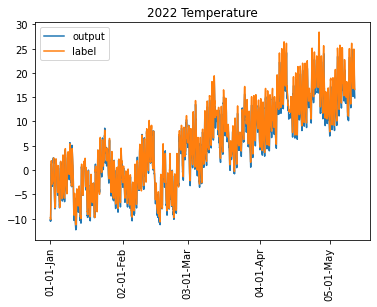

<Figure size 864x216 with 0 Axes>

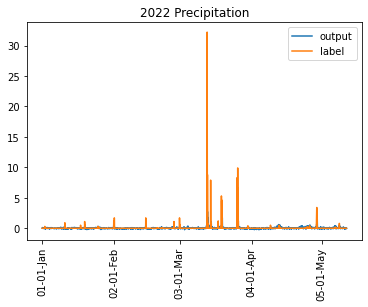

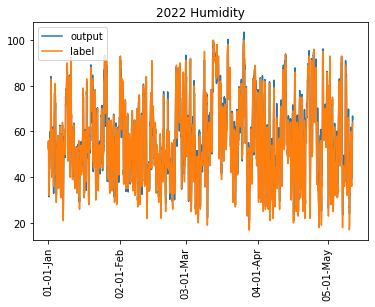

1000개씩 추출


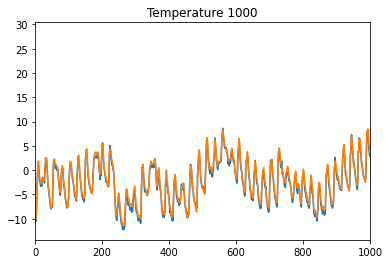

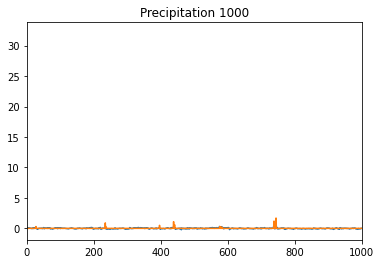

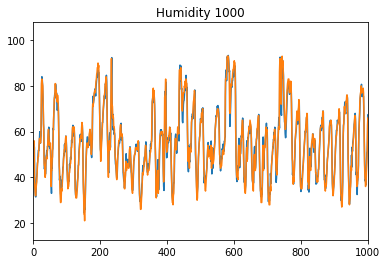

In [ ]:
# ------------------------- 학습시킨 모델 불러오기 ------------------------------
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

model = torch.load('/content/drive/MyDrive/model_useTotal.pt', map_location=device)
model.eval()
print(model)



# ----------------------------- Test & Plotting -----------------------------
plot_output1 = [] # 기온
plot_output2 = [] # 강수량
plot_output3 = [] # 습도

import datetime
from matplotlib import dates

for i in range(len(final_test_images)):
    test_image = final_test_images[i].to(device)
    test_image = test_image.double()
    test_x = final_test_x[i].to(device)
    output = model(test_image, test_x)
    for j in output:
        plot_output1.append(float(j[0]))
        plot_output2.append(float(j[1]))
        plot_output3.append(float(j[2]))
plot_output1 = np.array(plot_output1)
plot_output2 = np.array(plot_output2)
plot_output3 = np.array(plot_output3)

print(len(plot_output1)) #3139

plot_label1 = []
plot_label2 = []
plot_label3 = []
for y in test_y:
    plot_label1.append(y[0][0])
    plot_label2.append(y[0][1])
    plot_label3.append(y[0][2])
plot_label1 = np.array(plot_label1)
plot_label2 = np.array(plot_label2)
plot_label3 = np.array(plot_label3)

time = datetime.datetime(2022, 1, 1, 0)
plus_one_day = datetime.timedelta(days=1)
plus_one_month = datetime.timedelta(days=30)

ticklabel_orgin = []
ticklabel = []
ticklabel_orgin = [0, 24 * 31, 24 * (31 + 28), 24 * (31 + 28 + 31), 24 * (31 + 28 + 31 + 30)]
ticklabel = [time.strftime('%m-%d-%h'),
             (time+datetime.timedelta(days=31)).strftime('%m-%d-%h'),
             (time+datetime.timedelta(days=31 + 28)).strftime('%m-%d-%h'),
             (time+datetime.timedelta(days=31 + 28 + 31)).strftime('%m-%d-%h'),
             (time+datetime.timedelta(days=31 + 28 + 31 + 30)).strftime('%m-%d-%h'),
             ]

x = np.array(range(0, len(plot_output1)))
import matplotlib.pyplot as plt
plt.plot(x, plot_output1, label="output")
plt.plot(x, plot_label1, label="label")
plt.title('2022 Temperature')
plt.legend()
plt.xticks(ticklabel_orgin, ticklabel, rotation=90)
plt.figure(figsize=(12, 3))
plt.show()

plt.plot(x, plot_output2, label="output")
plt.plot(x, plot_label2, label="label")
plt.title('2022 Precipitation')
plt.legend()
plt.xticks(ticklabel_orgin, ticklabel, rotation=90)
plt.show()

plt.plot(x, plot_output3, label="output")
plt.plot(x, plot_label3, label="label")
plt.title('2022 Humidity')
plt.legend()
plt.xticks(ticklabel_orgin, ticklabel, rotation=90)
plt.show()

print('1000개씩 추출')
plt.plot(x, plot_output1, label="output")
plt.plot(x, plot_label1, label="label")
plt.xlim(0, 1000)
plt.title('Temperature 1000')
plt.show()

plt.plot(x, plot_output2, label="output")
plt.plot(x, plot_label2, label="label")
plt.xlim(0, 1000)
plt.title('Precipitation 1000')
plt.show()

plt.plot(x, plot_output3, label="output")
plt.plot(x, plot_label3, label="label")
plt.xlim(0, 1000)
plt.title('Humidity 1000')
plt.show()

# 학습시킨 모델 저장

In [ ]:
PATH = './'

torch.save(model, PATH + 'model_useTotal.pt')  # 전체 모델 저장